# German Credit Risk Prediction with PyTorch
This notebook trains a neural network to classify bank clients as risky or not, using PyTorch and a custom cost function.

In [18]:
# Submission number
submission_number = 27

In [1]:
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [20]:
def compute_costs(LoanAmount):
     return({'Risk_No Risk': 5.0 + .6 * LoanAmount, 'No Risk_No Risk': 1.0 - .05 * LoanAmount,
         'Risk_Risk': 1.0, 'No Risk_Risk': 1.0})

In [21]:
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
   '''
   A custom metric for the German credit dataset
   '''
   real_prop = {'Risk': .02, 'No Risk': .98}
   train_prop = {'Risk': 1/3, 'No Risk': 2/3}
   custom_weight = {'Risk': real_prop['Risk']/train_prop['Risk'], 'No Risk': real_prop['No Risk']/train_prop['No Risk']}
   costs = compute_costs(solution['LoanAmount'])
   y_true = solution['Risk']
   y_pred = submission['Risk']
   loss = (y_true=='Risk') * custom_weight['Risk'] *\
               ((y_pred=='Risk') * costs['Risk_Risk'] + (y_pred=='No Risk') * costs['Risk_No Risk']) +\
            (y_true=='No Risk') * custom_weight['No Risk'] *\
               ((y_pred=='Risk') * costs['No Risk_Risk'] + (y_pred=='No Risk') * costs['No Risk_No Risk'])
   return loss.mean()

In [2]:
import zipfile

zip_file_path = 'dsb-24-german-credit.zip'

test_file_path = 'german_credit_test.csv'
train_file_path = 'german_credit_train.csv'
submission_file_path = 'german_credit_test_submission.csv'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(test_file_path) as csv_file:
        df_test = pd.read_csv(csv_file)
    with zip_ref.open(train_file_path) as csv_file:
        df_train = pd.read_csv(csv_file)
    with zip_ref.open(submission_file_path) as csv_file:
        df_submission = pd.read_csv(csv_file)

df_train

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,greater_200,27,credits_paid_to_date,furniture,4650,less_100,1_to_4,3,male,none,...,savings_insurance,40,none,own,1,skilled,1,none,yes,No Risk
3995,0_to_200,11,prior_payments_delayed,furniture,250,greater_1000,4_to_7,3,male,none,...,car_other,32,bank,own,1,unemployed,1,none,yes,No Risk
3996,no_checking,32,outstanding_credit,appliances,6536,unknown,greater_7,5,male,co-applicant,...,unknown,54,stores,own,2,unskilled,2,yes,yes,Risk
3997,0_to_200,38,outstanding_credit,other,1597,500_to_1000,greater_7,3,female,co-applicant,...,savings_insurance,27,stores,own,1,skilled,1,none,yes,Risk


In [ ]:
df_train['is_train'] = 1
df_test['is_train'] = 0
df_test['Risk'] = np.nan

full_df = pd.concat([df_train, df_test], axis=0)

target_col = 'Risk'
id_col = 'Id'
ignore_cols = [target_col, id_col, 'is_train']

categorical_cols = full_df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ignore_cols]
numerical_cols = full_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ignore_cols]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
full_df[numerical_cols] = scaler.fit_transform(full_df[numerical_cols])

df_train = full_df[full_df['is_train'] == 1].drop(columns=['is_train'])
df_test = full_df[full_df['is_train'] == 0].drop(columns=['is_train', 'Risk'])

label_map = {'No Risk': 0, 'Risk': 1}
df_train['label'] = df_train['Risk'].map(label_map)

train_data, val_data = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)

class CreditDataset(Dataset):
    def __init__(self, df, cat_cols, num_cols, label_col=None):
        self.cat_data = df[cat_cols].values.astype('int64')
        self.num_data = df[num_cols].values.astype('float32')
        self.loan_amount = df['LoanAmount'].values.astype('float32')
        self.has_labels = label_col in df.columns
        if self.has_labels:
            self.labels = df[label_col].values.astype('float32')

    def __len__(self):
        return len(self.num_data)

    def __getitem__(self, idx):
        item = {
            'categorical': torch.tensor(self.cat_data[idx], dtype=torch.long),
            'numerical': torch.tensor(self.num_data[idx], dtype=torch.float32),
            'loan_amount': torch.tensor(self.loan_amount[idx], dtype=torch.float32),
        }
        if self.has_labels:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

train_dataset = CreditDataset(train_data, categorical_cols, numerical_cols, label_col='label')
val_dataset = CreditDataset(val_data, categorical_cols, numerical_cols, label_col='label')

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def get_categorical_cardinalities(encoders):
    return {col: len(le.classes_) for col, le in encoders.items()}

categorical_cardinalities = get_categorical_cardinalities(label_encoders)
for col, card in categorical_cardinalities.items():
    print(f"{col}: {card}")

CheckingStatus: 4
CreditHistory: 5
LoanPurpose: 11
ExistingSavings: 5
EmploymentDuration: 5
Sex: 2
OthersOnLoan: 3
OwnsProperty: 4
InstallmentPlans: 3
Housing: 3
Job: 4
Telephone: 2
ForeignWorker: 2


In [ ]:
import torch.nn as nn

class GermanCreditNN(nn.Module):
    def __init__(self, categorical_cardinalities, num_numerical):
        super().__init__()

        self.embeddings = nn.ModuleList()
        self.embedding_output_dim = 0

        for cardinality in categorical_cardinalities:
            dim = cardinality
            self.embeddings.append(nn.Embedding(cardinality, dim))
            self.embedding_output_dim += dim

        input_size = self.embedding_output_dim + num_numerical

        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, categorical_input, numerical_input):
        embedded = [emb(categorical_input[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(embedded, dim=1)
        x = torch.cat([x_cat, numerical_input], dim=1)
        return self.model(x)

In [ ]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import copy

real_prop = {'Risk': 0.02, 'No Risk': 0.98}
train_prop = {'Risk': 1/3, 'No Risk': 2/3}
custom_weight = {
    'Risk': real_prop['Risk'] / train_prop['Risk'],
    'No Risk': real_prop['No Risk'] / train_prop['No Risk']
}

def train_model(model, train_loader, val_loader, device, epochs=20):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    pos_weight_value = torch.tensor([custom_weight['Risk'] / custom_weight['No Risk']]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_value)

    best_score = float('inf')
    best_model = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            cat = batch['categorical'].to(device)
            num = batch['numerical'].to(device)
            labels = batch['label'].to(device)

            logits = model(cat, num).squeeze()
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_probs = []
        val_labels = []
        val_loan_amounts = []

        with torch.no_grad():
            for batch in val_loader:
                cat = batch['categorical'].to(device)
                num = batch['numerical'].to(device)
                labels = batch['label'].to(device)
                loan_amount = batch['loan_amount']

                logits = model(cat, num).squeeze()
                probs = torch.sigmoid(logits)
                val_probs.extend(probs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_loan_amounts.extend(loan_amount.cpu().numpy())

        val_preds = (np.array(val_probs) >= 0.5).astype(int)

        solution_df = pd.DataFrame({
            'Risk': ['Risk' if y == 1 else 'No Risk' for y in val_labels],
            'LoanAmount': val_loan_amounts
        })
        submission_df = pd.DataFrame({
            'Risk': ['Risk' if y == 1 else 'No Risk' for y in val_preds]
        })

        cost_score = score(solution_df, submission_df, row_id_column_name=None)
        acc = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Val Acc: {acc:.4f} | Cost Score: {cost_score:.5f}")

        if cost_score < best_score:
            best_score = cost_score
            best_model = copy.deepcopy(model.state_dict())

    print(f"Best cost score achieved: {best_score:.5f}")
    model.load_state_dict(best_model)
    return model

In [ ]:
categorical_cardinalities = [len(label_encoders[col].classes_) for col in categorical_cols]
num_numerical = len(numerical_cols)

model = GermanCreditNN(categorical_cardinalities, num_numerical)

trained_model = train_model(model, train_loader, val_loader, device, epochs=20)

Epoch 1/20 | Loss: 6.1999 | Val Acc: 0.7275 | Cost Score: 1.05465
Epoch 2/20 | Loss: 5.2511 | Val Acc: 0.7512 | Cost Score: 1.05923
Epoch 3/20 | Loss: 4.7643 | Val Acc: 0.7575 | Cost Score: 1.06158
Epoch 4/20 | Loss: 4.2556 | Val Acc: 0.7712 | Cost Score: 1.06160
Epoch 5/20 | Loss: 3.7672 | Val Acc: 0.7825 | Cost Score: 1.06159
Epoch 6/20 | Loss: 3.3453 | Val Acc: 0.7875 | Cost Score: 1.06282
Epoch 7/20 | Loss: 3.0113 | Val Acc: 0.7913 | Cost Score: 1.06326
Epoch 8/20 | Loss: 2.6245 | Val Acc: 0.7837 | Cost Score: 1.06766
Epoch 9/20 | Loss: 2.2982 | Val Acc: 0.7788 | Cost Score: 1.06973
Epoch 10/20 | Loss: 2.0359 | Val Acc: 0.7700 | Cost Score: 1.07254
Epoch 11/20 | Loss: 1.9589 | Val Acc: 0.7762 | Cost Score: 1.07114
Epoch 12/20 | Loss: 1.6075 | Val Acc: 0.7775 | Cost Score: 1.07061
Epoch 13/20 | Loss: 1.4342 | Val Acc: 0.7638 | Cost Score: 1.07425
Epoch 14/20 | Loss: 1.3707 | Val Acc: 0.7688 | Cost Score: 1.07297
Epoch 15/20 | Loss: 1.1362 | Val Acc: 0.7625 | Cost Score: 1.07483
Epoc

Prediction counts: {'No Risk': 736, 'Risk': 64}
True label counts: {'No Risk': 534, 'Risk': 266}


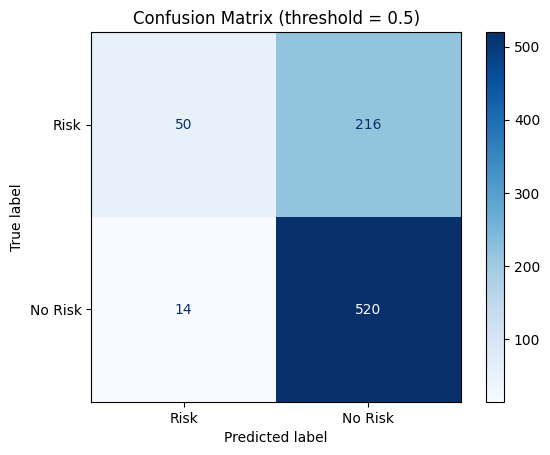

Custom Cost Score @ threshold 0.5: 1.08756


1.0875641260385513

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_on_validation(model, val_loader, threshold=0.5):
    model.eval()
    val_preds = []
    val_probs = []
    val_labels = []
    val_loan_amounts = []

    with torch.no_grad():
        for batch in val_loader:
            cat = batch['categorical'].to(device)
            num = batch['numerical'].to(device)
            labels = batch['label'].to(device)
            loan_amount = batch['loan_amount']

            probs = model(cat, num).squeeze()
            preds = (probs >= threshold).int()

            val_probs.extend(probs.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loan_amounts.extend(loan_amount.cpu().numpy())

    pred_labels = ['Risk' if p == 1 else 'No Risk' for p in val_preds]
    true_labels = ['Risk' if y == 1 else 'No Risk' for y in val_labels]

    print("Prediction counts:", pd.Series(pred_labels).value_counts().to_dict())
    print("True label counts:", pd.Series(true_labels).value_counts().to_dict())

    cm = confusion_matrix(true_labels, pred_labels, labels=["Risk", "No Risk"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Risk", "No Risk"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix (threshold = {threshold})")
    plt.show()

    solution_df = pd.DataFrame({
        'Risk': true_labels,
        'LoanAmount': val_loan_amounts
    })

    submission_df = pd.DataFrame({
        'Risk': pred_labels
    })

    cost = score(solution_df, submission_df, row_id_column_name=None)
    print(f"Custom Cost Score @ threshold {threshold}: {cost:.5f}")

    return cost

# Run analysis at default threshold
evaluate_on_validation(trained_model, val_loader, threshold=0.5)


--- Threshold: 0.3 ---
Prediction counts: {'No Risk': 667, 'Risk': 133}
True label counts: {'No Risk': 534, 'Risk': 266}


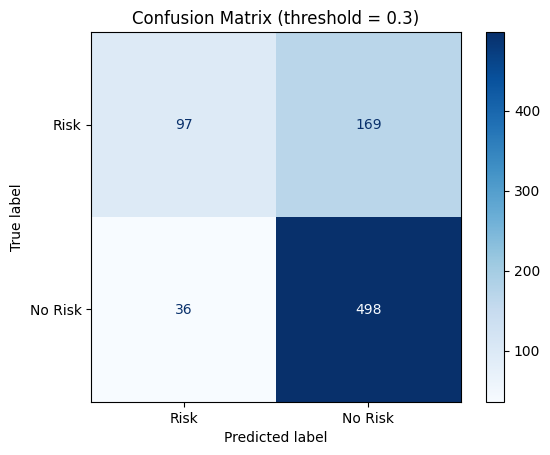

Custom Cost Score @ threshold 0.3: 1.07303

--- Threshold: 0.35 ---
Prediction counts: {'No Risk': 690, 'Risk': 110}
True label counts: {'No Risk': 534, 'Risk': 266}


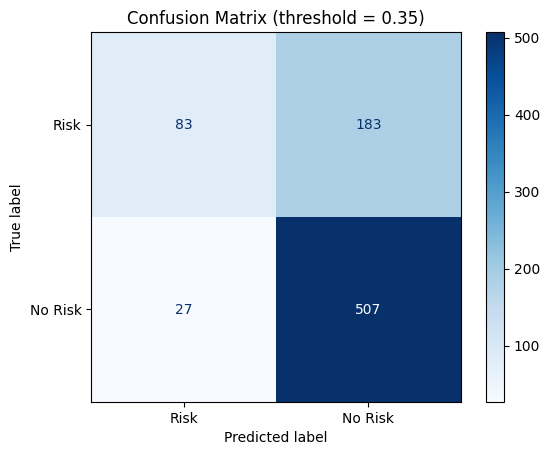

Custom Cost Score @ threshold 0.35: 1.07703

--- Threshold: 0.4 ---
Prediction counts: {'No Risk': 706, 'Risk': 94}
True label counts: {'No Risk': 534, 'Risk': 266}


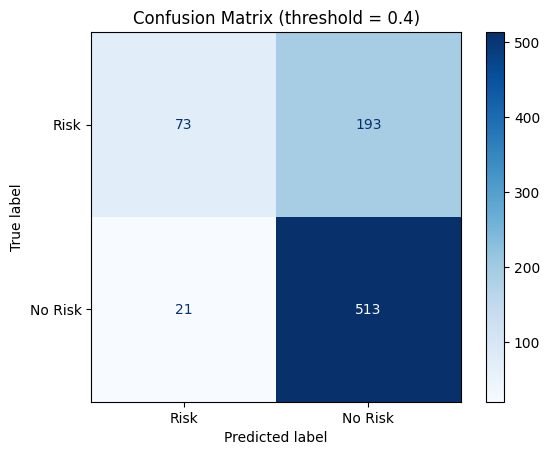

Custom Cost Score @ threshold 0.4: 1.08034

--- Threshold: 0.45 ---
Prediction counts: {'No Risk': 724, 'Risk': 76}
True label counts: {'No Risk': 534, 'Risk': 266}


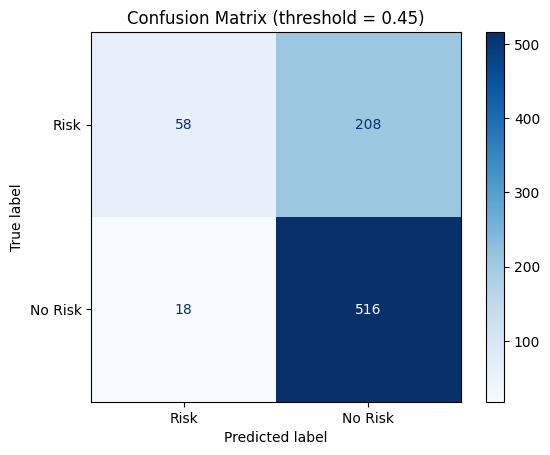

Custom Cost Score @ threshold 0.45: 1.08521

--- Threshold: 0.5 ---
Prediction counts: {'No Risk': 736, 'Risk': 64}
True label counts: {'No Risk': 534, 'Risk': 266}


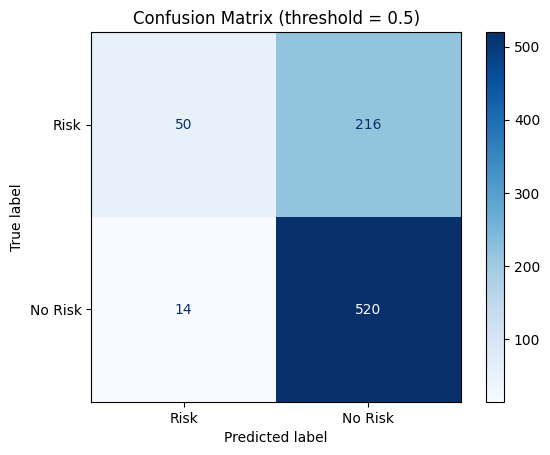

Custom Cost Score @ threshold 0.5: 1.08756


In [29]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
scores = []

for thresh in thresholds:
    print(f"\n--- Threshold: {thresh} ---")
    cost = evaluate_on_validation(trained_model, val_loader, threshold=thresh)
    scores.append((thresh, cost))


--- Threshold: 0.25 ---
Prediction counts: {'No Risk': 650, 'Risk': 150}
True label counts: {'No Risk': 534, 'Risk': 266}


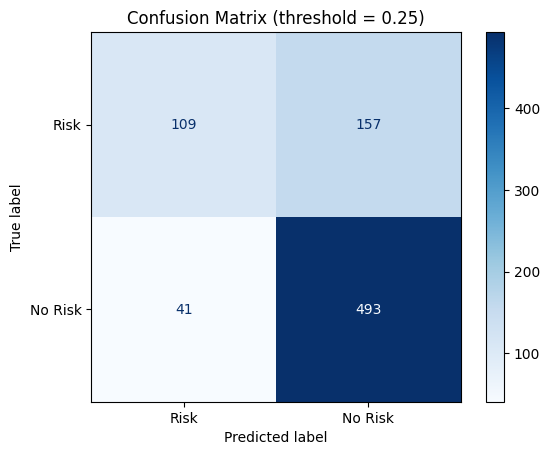

Custom Cost Score @ threshold 0.25: 1.06920

--- Threshold: 0.26 ---
Prediction counts: {'No Risk': 654, 'Risk': 146}
True label counts: {'No Risk': 534, 'Risk': 266}


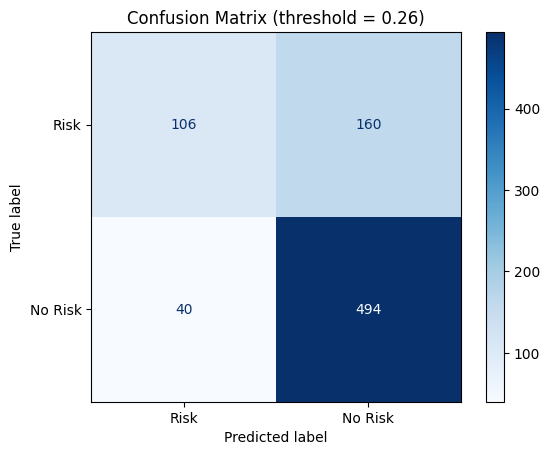

Custom Cost Score @ threshold 0.26: 1.07019

--- Threshold: 0.27 ---
Prediction counts: {'No Risk': 658, 'Risk': 142}
True label counts: {'No Risk': 534, 'Risk': 266}


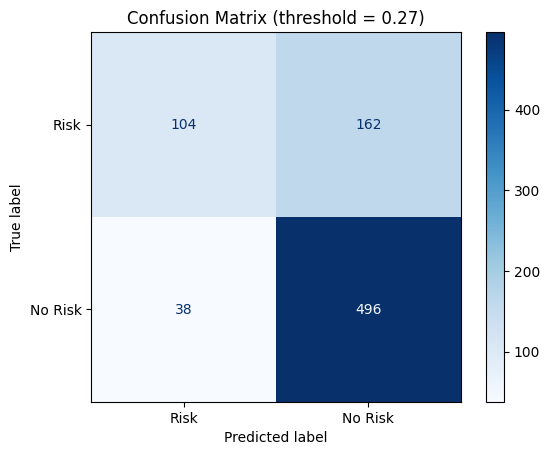

Custom Cost Score @ threshold 0.27: 1.07084

--- Threshold: 0.28 ---
Prediction counts: {'No Risk': 661, 'Risk': 139}
True label counts: {'No Risk': 534, 'Risk': 266}


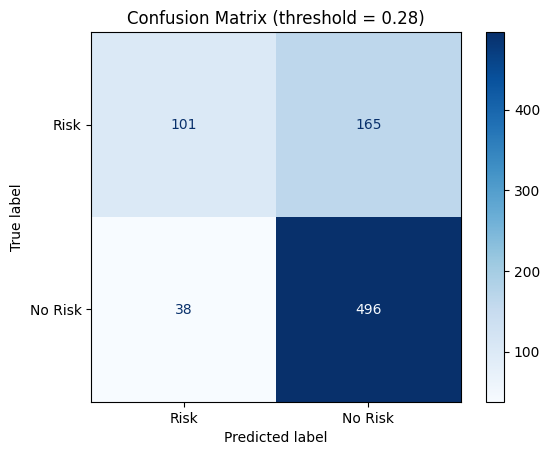

Custom Cost Score @ threshold 0.28: 1.07184

--- Threshold: 0.29 ---
Prediction counts: {'No Risk': 664, 'Risk': 136}
True label counts: {'No Risk': 534, 'Risk': 266}


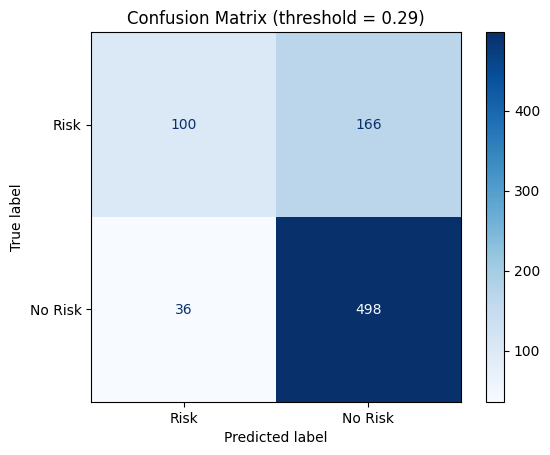

Custom Cost Score @ threshold 0.29: 1.07199

--- Threshold: 0.3 ---
Prediction counts: {'No Risk': 667, 'Risk': 133}
True label counts: {'No Risk': 534, 'Risk': 266}


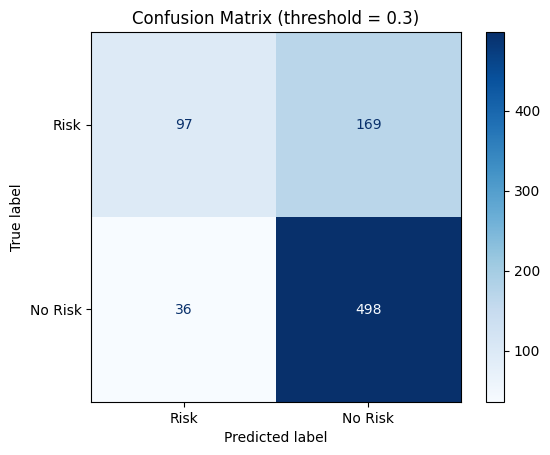

Custom Cost Score @ threshold 0.3: 1.07303

--- Threshold: 0.31 ---
Prediction counts: {'No Risk': 673, 'Risk': 127}
True label counts: {'No Risk': 534, 'Risk': 266}


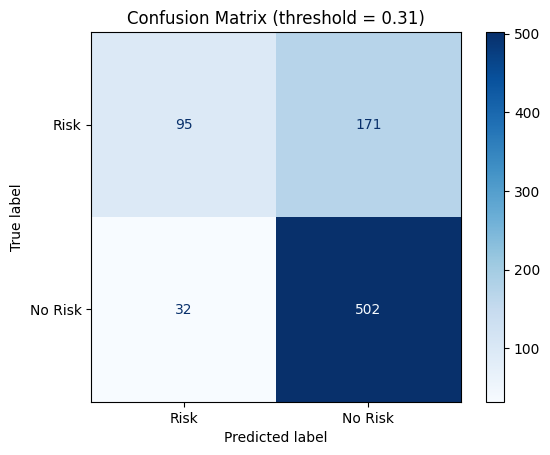

Custom Cost Score @ threshold 0.31: 1.07339

--- Threshold: 0.32 ---
Prediction counts: {'No Risk': 676, 'Risk': 124}
True label counts: {'No Risk': 534, 'Risk': 266}


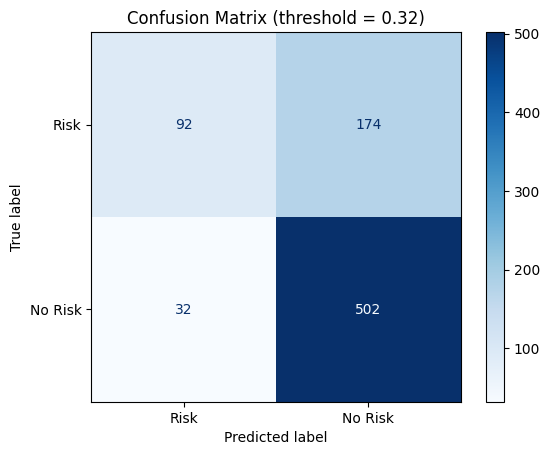

Custom Cost Score @ threshold 0.32: 1.07443

--- Threshold: 0.33 ---
Prediction counts: {'No Risk': 677, 'Risk': 123}
True label counts: {'No Risk': 534, 'Risk': 266}


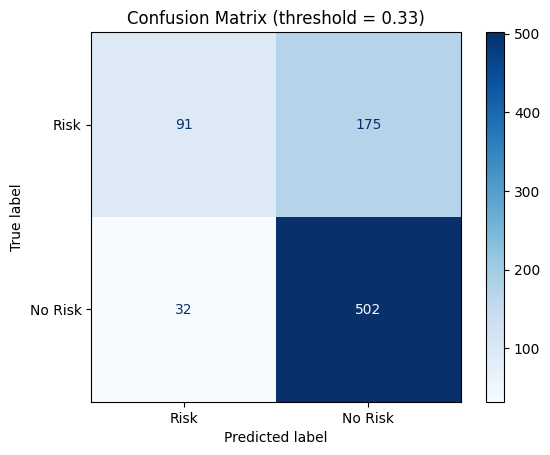

Custom Cost Score @ threshold 0.33: 1.07481


In [30]:
fine_thresholds = [round(x, 2) for x in np.arange(0.25, 0.33, 0.01)]
fine_scores = []

for thresh in fine_thresholds:
    print(f"\n--- Threshold: {thresh} ---")
    cost = evaluate_on_validation(trained_model, val_loader, threshold=thresh)
    fine_scores.append((thresh, cost))

In [ ]:
test_dataset = CreditDataset(df_test, categorical_cols, numerical_cols)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

def predict_test(model, test_loader, threshold=0.10):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            cat = batch['categorical'].to(device)
            num = batch['numerical'].to(device)
            probs = model(cat, num).squeeze()
            preds = (probs >= threshold).cpu().numpy()
            all_preds.extend(preds)

    return ['Risk' if p == 1 else 'No Risk' for p in all_preds]

final_preds = predict_test(trained_model, test_loader, threshold=0.10)

submission_df = pd.DataFrame({
    'Id': df_test['Id'],
    'Risk': final_preds
})

submission_df['Id'] = submission_df['Id'].astype(int)
filename = f'predictions_result_{submission_number}.csv'
submission_df.to_csv('results/' + filename, index=False)
print(f"✅ Submission saved as: {filename}")
submission_df.head()

✅ Submission saved as: predictions_result_27.csv


,Id,Risk
0,0,No Risk
1,1,No Risk
2,2,Risk
3,3,No Risk
4,4,No Risk


In [32]:
print("Shape:", submission_df.shape)
print("Columns:", submission_df.columns.tolist())
print("Unique labels:", submission_df['Id'].unique())
print("Any NaNs?", submission_df.isnull().any().to_dict())
submission_df.head()

Shape: (1001, 2)
Columns: ['Id', 'Risk']
Unique labels: [   0    1    2 ...  998  999 1000]
Any NaNs? {'Id': False, 'Risk': False}


,Id,Risk
0,0,No Risk
1,1,No Risk
2,2,Risk
3,3,No Risk
4,4,No Risk


In [33]:
print("Duplicate IDs?", submission_df['Id'].duplicated().any())
print("Are all IDs in the expected range?", submission_df['Id'].min(), submission_df['Id'].max())

Duplicate IDs? False
Are all IDs in the expected range? 0 1000


In [34]:
print("Val set size:", len(val_loader.dataset))
print("Train set size:", len(train_loader.dataset))

Val set size: 800
Train set size: 3199
